In [61]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Activation
from keras.layers.merge import Maximum, Concatenate
from keras.models import Model
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from model import Model as Model2
import pickle
from sklearn.datasets import load_svmlight_file


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "white")
print (3)

3


In [62]:
class MalGAN():
    def __init__(self, model_name):
        self.apifeature_dims = 3514
        self.z_dims = 100   # noise appended at the end of example
        self.model_name = model_name

        self.hide_layers = 256
        self.generator_layers = [self.apifeature_dims+self.z_dims, self.hide_layers, self.apifeature_dims]
        self.substitute_detector_layers = [self.apifeature_dims, self.hide_layers, 1]
        self.blackbox, self.sess = self.build_blackbox_detector(self.model_name)
        self.optimizer = Adam(lr=0.001)
        
        # Build and compile the substitute_detector
        self.substitute_detector = self.build_substitute_detector()
        self.substitute_detector.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        
        # Build the generator
        self.generator = self.build_generator()

        # The generator takes malware and noise as input and generates adversarial malware examples
        example = Input(shape=(self.apifeature_dims,))
        noise = Input(shape=(self.z_dims,))
        input = [example, noise]
        malware_examples = self.generator(input)

        # For the combined model we will only train the generator
        self.substitute_detector.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.substitute_detector(malware_examples)

        # The combined model  (stacked generator and substitute_detector)
        self.combined = Model(input, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
        
    def build_generator(self):

        example = Input(shape=(self.apifeature_dims,))
        noise = Input(shape=(self.z_dims,))
        x = Concatenate(axis=1)([example, noise])
        for dim in self.generator_layers[1:]:
            x = Dense(dim)(x)
            x = Activation(activation='sigmoid')(x)
        x = Maximum()([example, x])
        generator = Model([example, noise], x, name='generator')
        generator.summary()
        return generator
    
    def build_substitute_detector(self):

        input = Input(shape=(self.substitute_detector_layers[0],))
        x = input
        for dim in self.substitute_detector_layers[1:]:
            x = Dense(dim)(x)
            x = Activation(activation='sigmoid')(x)
        substitute_detector = Model(input, x, name='substitute_detector')
        substitute_detector.summary()
        return substitute_detector    
    

    def build_blackbox_detector(self,model_name):
        
        PATH = "./adv_trained/{}.ckpt".format(model_name)
        # Clear the current graph in each run, to avoid variable duplication
        tf.reset_default_graph()
        model = Model2()
        saver = tf.train.Saver()
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
                    
        saver.restore(sess, PATH)
        print ("load model from:", PATH)
        
        return model, sess
        
    def train(self, epochs, batch_size):
        
        model = self.blackbox
        sess = self.sess
        
                
        # Load test dataset (all malware)
        seed_dict = pickle.load(open('feat_dict.pickle', 'rb'), encoding='latin1')
        features = []
        sha1 = []
        dist_dict = {} # [key]: hash [value]: L0 distance
        for key in seed_dict:
            seed_dict[key] = seed_dict[key].toarray()[0]
            features.append(seed_dict[key])
            sha1.append(key)
        feed_feat = np.stack(features)
        xtest_mal, ytest_mal = feed_feat, np.ones(len(feed_feat))
        

        # Load training dataset
        train_x, train_y = load_svmlight_file("train_data.libsvm",
                                       n_features=3514,
                                       multilabel=False, 
                                       zero_based=False,
                                       query_id=False)
        
        train_x = train_x.toarray()
        xtrain_ben = train_x[6896:]
        ytrain_ben = train_y[6896:]
        xtrain_mal = train_x[0:6896]              
        ytrain_mal = train_y[0:6896]
        
        # Since the training dataset is unbalanced, we randomly choose sample from benign dataset
        # and add them to the end to make up the gap
        idx = np.random.randint(0, xtrain_ben.shape[0], 6896 - 6294)
        add_on = xtrain_ben[idx]
        add_on_label = ytrain_ben[idx]
        xtrain_ben = np.concatenate((xtrain_ben, add_on), axis=0)
        ytrain_ben = np.concatenate((ytrain_ben, add_on_label), axis = 0)

        Test_TPR = []
        d_loss_list, g_loss_list = [], []
        
        
        for epoch in range(epochs):
            
            # Each epoch goes through all the data in the training set
            start = 0                
                
            for step in range(xtrain_mal.shape[0] // batch_size):
                
                # ---------------------
                #  Train substitute_detector
                # ---------------------

                xmal_batch = xtrain_mal[start : start + batch_size]  
                noise = np.random.uniform(0, 1, (batch_size, self.z_dims))

                xben_batch = xtrain_ben[start : start + batch_size]
                
                # predict using blackbox detector              
                # start = start + batch_size
                yben_batch = sess.run(model.y_pred,\
                    feed_dict={model.x_input:xben_batch})

                # Generate a batch of new malware examples
                gen_examples = self.generator.predict([xmal_batch, noise])
                ymal_batch = sess.run(model.y_pred,\
                                      feed_dict={model.x_input:np.ones(gen_examples.shape)*(gen_examples > 0.5)})
                
                # Train the substitute_detector
                d_loss_real = self.substitute_detector.train_on_batch(xben_batch, yben_batch)
                d_loss_fake = self.substitute_detector.train_on_batch(gen_examples, ymal_batch)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                

                # ---------------------
                #  Train Generator
                # ---------------------

                noise = np.random.uniform(0, 1, (batch_size, self.z_dims))
                g_loss = self.combined.train_on_batch([xmal_batch,noise], np.zeros((batch_size, 1)))

            
            # After each epoch, Evaluate evasion performance on the test dataset
            # try different noise for 3 times
            for j in range(3):
                noise = np.random.uniform(0, 1, (xtest_mal.shape[0], self.z_dims))
                gen_examples = self.generator.predict([xtest_mal, noise])
                    
                TPR = sess.run(model.accuracy,\
                        feed_dict={model.x_input:np.ones(gen_examples.shape)*(gen_examples > 0.5), model.y_input: np.ones(gen_examples.shape[0],)})
            
                Test_TPR.append(TPR)
            
                transformed_to_bin = np.ones(gen_examples.shape)*(gen_examples > 0.5)
            
                pred_y_label = sess.run(model.y_pred,\
                                     feed_dict={model.x_input:np.ones(gen_examples.shape)*(gen_examples > 0.5)})
            
            
            
                # remove successfully evaded malware examples from xtest_mal
                i = 0
                while i  < pred_y_label.shape[0]:
                    if pred_y_label[i] == 0: # should be 1 but predict 0
                    #print(sha1[i], xtrain_mal[i])
                    # calculate L0 distance and put to dictionary
                        L0 = np.sum(transformed_to_bin[i]) - np.sum(xtest_mal[i]) #insertion only
                        dist_dict[sha1[i]] = L0  # [key]: hash [value]: L0 distance
                        xtest_mal = np.delete(xtest_mal, i, 0)
                        pred_y_label = np.delete(pred_y_label, i, 0)
                        sha1 = sha1[:i] + sha1[i+1:]
                    else:
                        i += 1
            
                print("remaining malware examples:", xtest_mal.shape[0])
                if xtest_mal.shape[0] == 0:
                    break #successful evade all

        
            # Print and record the progress
            print("[MalGAN] epoch(%d) [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch+1, d_loss[0], 100*d_loss[1], g_loss))
            print("[Classifier] Test TPR on remaining test data: %f" % (Test_TPR[-1]))
            d_loss_list.append(d_loss[0])
            g_loss_list.append(g_loss)
            if xtest_mal.shape[0] == 0:
                break #successful evade all
            

        sess.close()
        
        # AFTER all epochs
        # Plot the progress --> loss
        d_loss_df = pd.DataFrame(dict(epoch =np.arange(1, len(d_loss_list)+1),\
                                      dataset = "d loss",\
                                      loss = np.asarray(d_loss_list, dtype=np.float32)))
        g_loss_df = pd.DataFrame(dict(epoch =np.arange(1, len(g_loss_list)+1),\
                                     dataset = "g loss",\
                                     loss = np.asarray(g_loss_list, dtype=np.float32)))

        loss_df = pd.concat([d_loss_df,g_loss_df], axis=0)       
        plt.figure()
        loss_plot = sns.lineplot(x = 'epoch', y = 'loss', hue = 'dataset' , data = loss_df)
        handles, labels = loss_plot.get_legend_handles_labels()
        loss_plot.legend(handles=handles[1:], labels=labels[1:])
        plt.show()
        fig = loss_plot.get_figure()
        fig.savefig("{}_loss".format(self.model_name))  # save loss plot
        
        # get corresponding dataframe for different models
        ERA = []
        success_num = 0
        # Calculate ERA for each L0 distance
        for i in range(3515): # 0 - 3514 features
            for key in dist_dict:
                if dist_dict[key] == i:
                    success_num += 1
            ERA.append((3435 - success_num) / 3435)
        
        # report ERA if not completely evaded
        if ERA[-1] != 0:
            print("{} is not completely evaded after {} epochs. ERA = {}".format(self.model_name, epochs, ERA[-1]))
            
            
        if self.model_name == 'baseline_checkpoint':
                
            # Plot the success rate and modified bytes relation for a model
            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Baseline',\
                                      L0 = np.arange(0, 3515)))
            
        if self.model_name == "baseline_adv_delete_one":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Adv Retrain A',\
                                      L0 = np.arange(0, 3515)))
            
        
        if self.model_name == "robust_delete_one":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust A',\
                                      L0 = np.arange(0, 3515)))
        
        if self.model_name == "baseline_adv_insert_one":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Adv Retrain B',\
                                      L0 = np.arange(0, 3515)))
        
        if self.model_name == "robust_insert_one":
            
            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust B',\
                                      L0 = np.arange(0, 3515)))
            
        if self.model_name == "baseline_adv_delete_two":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Adv Retrain C',\
                                      L0 = np.arange(0, 3515)))
        
        
        if self.model_name == "robust_delete_two":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust C',\
                                      L0 = np.arange(0, 3515)))
        
        if self.model_name == "baseline_adv_insert_rootallbutone":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Adv Retrain D',\
                                      L0 = np.arange(0, 3515)))
            
        if self.model_name == "adv_keep_twocls":
            
            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Ensemble D Base Learner',\
                                      L0 = np.arange(0, 3515)))
        
        
        if self.model_name == "robust_monotonic":
            
            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust E',\
                                      L0 = np.arange(0, 3515)))
        
        if self.model_name == "baseline_adv_combine_two":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Adv Retrain A+B',\
                                      L0 = np.arange(0, 3515)))
            
        if self.model_name == "adv_del_twocls":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Ensemble A+B Base Learner',\
                                      L0 = np.arange(0, 3515)))
        
        if self.model_name == "robust_combine_two_v2_e18":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust A+B',\
                                      L0 = np.arange(0, 3515)))
        
        if self.model_name == "robust_insert_allbutone":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust D',\
                                      L0 = np.arange(0, 3515)))
            
        if self.model_name == "robust_combine_three_e17":

            model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                         model = 'Robust A+B+E',\
                                      L0 = np.arange(0, 3515)))
        
        return model_df

INFO:tensorflow:Restoring parameters from ./adv_trained/baseline_checkpoint.ckpt
load model from: ./adv_trained/baseline_checkpoint.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 900,097
Trainable params: 900,097
Non-trainable params: 0
____________________________________

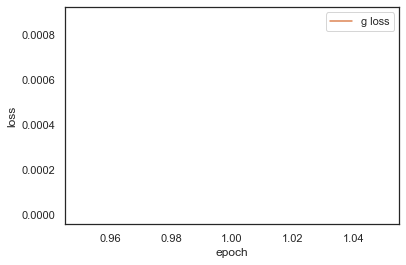

INFO:tensorflow:Restoring parameters from ./adv_trained/robust_delete_one.ckpt
load model from: ./adv_trained/robust_delete_one.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 900,097
Trainable params: 900,097
Non-trainable params: 0
________________________________________

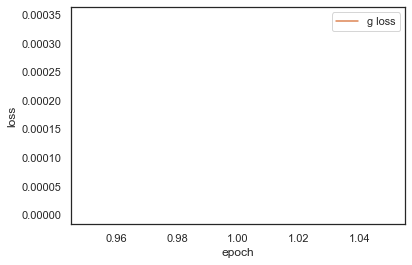

INFO:tensorflow:Restoring parameters from ./adv_trained/robust_insert_one.ckpt
load model from: ./adv_trained/robust_insert_one.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 900,097
Trainable params: 900,097
Non-trainable params: 0
________________________________________

remaining malware examples: 160
remaining malware examples: 160
remaining malware examples: 160
[MalGAN] epoch(23) [D loss: 0.008750, acc.: 100.00%] [G loss: 2.289599]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 160
remaining malware examples: 160
remaining malware examples: 160
[MalGAN] epoch(24) [D loss: 0.009537, acc.: 100.00%] [G loss: 2.360980]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 160
remaining malware examples: 160
remaining malware examples: 160
[MalGAN] epoch(25) [D loss: 0.005762, acc.: 100.00%] [G loss: 2.461150]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 160
remaining malware examples: 160
remaining malware examples: 160
[MalGAN] epoch(26) [D loss: 0.004615, acc.: 100.00%] [G loss: 2.561021]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 160
remaining malware examples: 160
remaining malware examples: 160
[MalGAN] epo

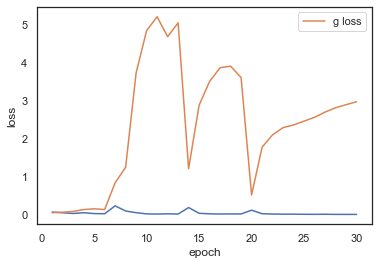

robust_insert_one is not completely evaded after 30 epochs. ERA = 0.046579330422125184
INFO:tensorflow:Restoring parameters from ./adv_trained/robust_delete_two.ckpt
load model from: ./adv_trained/robust_delete_two.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 900,097
Tra

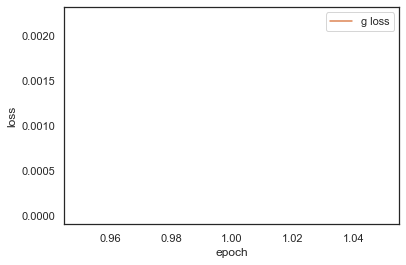

INFO:tensorflow:Restoring parameters from ./adv_trained/robust_insert_allbutone.ckpt
load model from: ./adv_trained/robust_insert_allbutone.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 900,097
Trainable params: 900,097
Non-trainable params: 0
____________________________

remaining malware examples: 3432
remaining malware examples: 3432
[MalGAN] epoch(22) [D loss: 0.000168, acc.: 100.00%] [G loss: 9.178831]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3432
remaining malware examples: 3432
remaining malware examples: 3432
[MalGAN] epoch(23) [D loss: 0.000145, acc.: 100.00%] [G loss: 9.389471]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3432
remaining malware examples: 3432
remaining malware examples: 3432
[MalGAN] epoch(24) [D loss: 0.000138, acc.: 100.00%] [G loss: 9.343170]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3432
remaining malware examples: 3432
remaining malware examples: 3432
[MalGAN] epoch(25) [D loss: 0.000123, acc.: 100.00%] [G loss: 9.498100]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3432
remaining malware examples: 3432
remaining malware examples: 3432
[MalGAN] epoch(26) [D loss: 0.

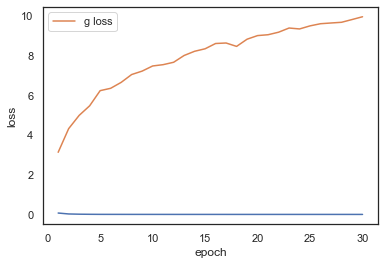

robust_insert_allbutone is not completely evaded after 30 epochs. ERA = 0.9991266375545852
INFO:tensorflow:Restoring parameters from ./adv_trained/robust_monotonic.ckpt
load model from: ./adv_trained/robust_monotonic.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 900,097
T

remaining malware examples: 3410
remaining malware examples: 3410
remaining malware examples: 3410
[MalGAN] epoch(22) [D loss: 0.000132, acc.: 100.00%] [G loss: 8.986468]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3410
remaining malware examples: 3410
remaining malware examples: 3410
[MalGAN] epoch(23) [D loss: 0.000129, acc.: 100.00%] [G loss: 8.931474]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3410
remaining malware examples: 3410
remaining malware examples: 3410
[MalGAN] epoch(24) [D loss: 0.000115, acc.: 100.00%] [G loss: 9.073795]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3410
remaining malware examples: 3410
remaining malware examples: 3410
[MalGAN] epoch(25) [D loss: 0.000110, acc.: 100.00%] [G loss: 9.088327]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3410
remaining malware examples: 3410
remaining malware examples: 34

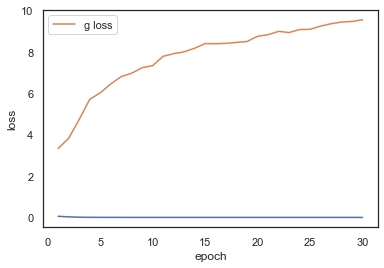

robust_monotonic is not completely evaded after 30 epochs. ERA = 0.992721979621543
INFO:tensorflow:Restoring parameters from ./adv_trained/robust_combine_two_v2_e18.ckpt
load model from: ./adv_trained/robust_combine_two_v2_e18.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params:

remaining malware examples: 161
remaining malware examples: 161
remaining malware examples: 161
[MalGAN] epoch(23) [D loss: 0.003013, acc.: 100.00%] [G loss: 0.473445]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 161
remaining malware examples: 161
remaining malware examples: 161
[MalGAN] epoch(24) [D loss: 0.004825, acc.: 100.00%] [G loss: 0.482419]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 161
remaining malware examples: 161
remaining malware examples: 161
[MalGAN] epoch(25) [D loss: 0.010064, acc.: 99.61%] [G loss: 0.303560]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 161
remaining malware examples: 161
remaining malware examples: 161
[MalGAN] epoch(26) [D loss: 0.008452, acc.: 99.61%] [G loss: 0.310771]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 161
remaining malware examples: 161
remaining malware examples: 161
[MalGAN] epoch

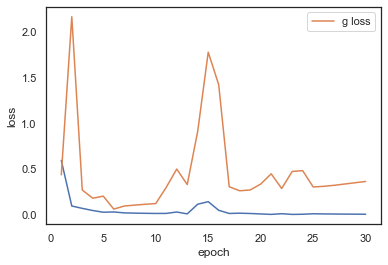

robust_combine_two_v2_e18 is not completely evaded after 30 epochs. ERA = 0.046870451237263466
INFO:tensorflow:Restoring parameters from ./adv_trained/robust_combine_three_e17.ckpt
load model from: ./adv_trained/robust_combine_three_e17.ckpt
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3514)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               899840    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Tot

remaining malware examples: 3407
remaining malware examples: 3407
remaining malware examples: 3407
[MalGAN] epoch(22) [D loss: 0.000105, acc.: 100.00%] [G loss: 9.196229]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3407
remaining malware examples: 3407
remaining malware examples: 3407
[MalGAN] epoch(23) [D loss: 0.000095, acc.: 100.00%] [G loss: 9.270517]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3407
remaining malware examples: 3407
remaining malware examples: 3407
[MalGAN] epoch(24) [D loss: 0.000095, acc.: 100.00%] [G loss: 9.210240]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3407
remaining malware examples: 3407
remaining malware examples: 3407
[MalGAN] epoch(25) [D loss: 0.000086, acc.: 100.00%] [G loss: 9.326871]
[Classifier] Test TPR on remaining test data: 1.000000
remaining malware examples: 3407
remaining malware examples: 3407
remaining malware examples: 34

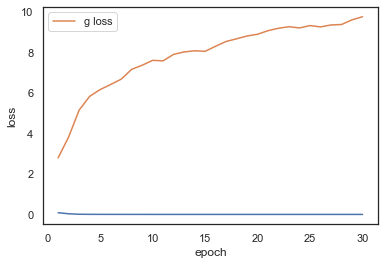

robust_combine_three_e17 is not completely evaded after 30 epochs. ERA = 0.991848617176128


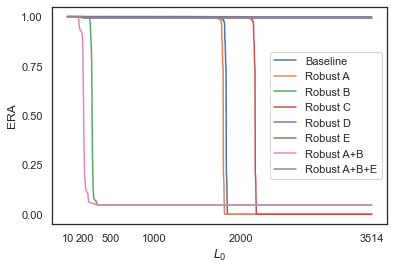

In [63]:
#models = ['adv_keep_twocls', 'adv_del_twocls']
#models = ['baseline_adv_delete_one', 'baseline_adv_insert_one', 'baseline_adv_delete_two', \
          #'baseline_adv_insert_rootallbutone', 'baseline_adv_combine_two']
models = ['baseline_checkpoint', 'robust_delete_one', 'robust_insert_one', 'robust_delete_two', \
          'robust_insert_allbutone', 'robust_monotonic', 'robust_combine_two_v2_e18', 'robust_combine_three_e17']
dataframes = []
#tf.compat.v1.disable_eager_execution()
for model in models:
    malgan = MalGAN(model)
    df = malgan.train(epochs = 30, batch_size= 128)
    dataframes.append(df)

data = pd.concat(dataframes, axis = 0)
plt.figure()
g = sns.lineplot(x = 'L0', y = 'ERA', data=data, hue = 'model')
plt.xlabel("$L_0$")
g.set(yticks = [0.00, 0.25, 0.50, 0.75, 1.00])
g.xaxis.set_major_locator(ticker.FixedLocator([10, 200, 500, 1000, 2000, 3514]))
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[0:], labels=labels[0:])
fig = g.get_figure()
fig.savefig("result")
plt.show()